In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import grad
from torch.autograd.functional import jacobian
from bco.train import train
from post_process import score_contours
from bco.training.models import build_model
from bco.training import default_params

In [5]:
t

tensor([-0.4061, -0.5860, -1.3463, -2.3679, -1.1447, -1.5176, -0.1033,  0.2801,
        -0.3165, -0.1488], requires_grad=True)

In [2]:
from data.half import gen

In [5]:
d = gen(10000)

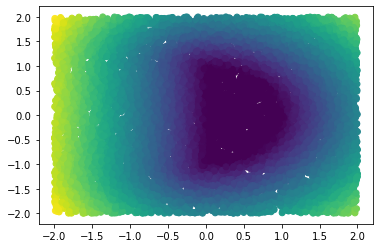

In [6]:
plt.scatter(d.x1, d.x2, c=d.sqJ)

In [10]:
def project_plane(X1, X2):
    feasible = X1 >= 0
    return X1 * feasible, X2

def project_circle(X1, X2):
    nrm = np.sqrt(X1**2 + X2**2)
    feasible = nrm <= 0.5
    return X1 / nrm /2 * (1-feasible) + X1 * feasible, X2 / nrm/2 * (1-feasible) + X2 * feasible

In [32]:
N = 1000
X1, X2 = np.meshgrid(np.linspace(-1,1,N), np.linspace(-1,1,N))
X1_ = np.copy(X1)
X2_ = np.copy(X2)
for i in range(10):
    X1, X2 = project_plane(X1, X2)
    X1, X2 = project_circle(X1, X2)
sqJ = np.sqrt((X1-X1_)**2 + (X2-X2_)**2)
classes = sqJ < 1e-6


X1_c, X2_c = project_circle(X1_, X2_)
X1_p, X2_p = project_plane(X1_, X2_)
sqJ_p = np.sqrt(X1_**2)
sqJ_c = 1/2 - np.sqrt(X1_**2 + X2_**2)
sqJ_in = np.minimum(sqJ_p, sqJ_c)

sqJ = sqJ * (1-classes) - sqJ_in * classes



(-1.0, 1.0, -1.0, 1.0)

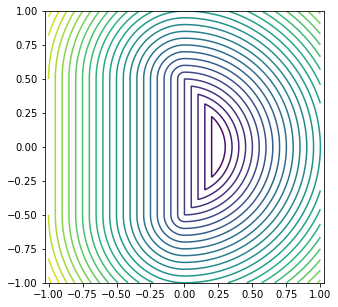

In [33]:
plt.figure(figsize=(5,5))
plt.contour(X1_,X2_,sqJ, 30)
plt.axis('equal')

In [90]:
default_params['model']['input_size'] = 2
default_params['model']['per_epoch_proj']['turned_on'] = True
default_params['model']['hidden_layers'] = [3,3]

In [148]:
model = build_model(default_params)
# model.projection('epoch')

In [149]:
L.project_weights(False, 0.5, 20, 1)

In [150]:
L = model._net[-1]

In [151]:
L.weight

Parameter containing:
tensor([[-0.2957,  0.4852, -0.1021]], requires_grad=True)

In [152]:
L.weight.norm()

tensor(0.5774, grad_fn=<NormBackward0>)

In [153]:
L.weight / L.weight.norm()

tensor([[-0.5122,  0.8405, -0.1768]], grad_fn=<DivBackward0>)

In [154]:
L.weight

Parameter containing:
tensor([[-0.2957,  0.4852, -0.1021]], requires_grad=True)

In [155]:
L.bias

Parameter containing:
tensor([-0.3132], requires_grad=True)

In [114]:
weight = torch.zeros((3,3))

In [120]:
stdv = 1. / np.sqrt(weight.size(1))
torch.nn.init.orthogonal_(weight, gain=stdv)

tensor([[ 0.1291, -0.0295,  0.5620],
        [-0.1886,  0.5409,  0.0717],
        [ 0.5302,  0.1996, -0.1113]])

In [121]:
weight @ weight.T

tensor([[ 3.3333e-01, -2.6722e-17,  1.9664e-17],
        [-2.6722e-17,  3.3333e-01, -5.4765e-17],
        [ 1.9664e-17, -5.4765e-17,  3.3333e-01]])

In [116]:
weight.svd().S

tensor([1.0000, 1.0000, 1.0000])

In [88]:
d = 10
v = 2/np.sqrt(d)
bias = torch.zeros(d)
N = 100000
vals = torch.zeros(N)
for i in range(N):
    bias.uniform_(-v,v)
    vals[i] = bias.norm()

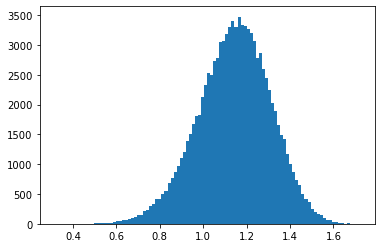

In [89]:
plt.hist(vals, 100);

In [50]:
L.weight

Parameter containing:
tensor([[-0.7040, -0.0662],
        [ 0.0662, -0.7040]], requires_grad=True)

In [36]:
L.weight.norm

<bound method Tensor.norm of Parameter containing:
tensor([[-0.7040, -0.0662],
        [ 0.0662, -0.7040]], requires_grad=True)>

In [29]:
L.bias

Parameter containing:
tensor([-0.2520,  0.4938], requires_grad=True)

In [30]:
L.bias.norm()

tensor(0.5544, grad_fn=<NormBackward0>)

In [29]:
# del model._net[-1]
# del model._net[-1]

In [30]:
model._net

Sequential(
  (0): BjorckLinear(in_features=2, out_features=2, bias=True)
  (1): GroupSort(num_groups: 1)
  (2): BjorckLinear(in_features=2, out_features=2, bias=True)
  (3): GroupSort(num_groups: 1)
  (4): BjorckLinear(in_features=2, out_features=1, bias=True)
)

In [31]:
W = []
for w in model._net:
    if hasattr(w, 'weight'):
        W.append(w.weight.data)

In [32]:
W0 = W[0]
W1 = W[1]
Wf = W[-1]

In [33]:
x = torch.randn(2)

In [34]:
W0.shape

torch.Size([2, 2])

In [36]:
W0.t() @ W0

tensor([[1.0000, 0.0000],
        [0.0000, 1.0000]])

In [38]:
(Wf.t()) @ (Wf)

tensor([[ 0.0374, -0.1897],
        [-0.1897,  0.9626]])

In [21]:
(W0.t() @ W1.t()) @ (W1 @ W0)

tensor([[ 1.0000e+00, -2.7756e-17],
        [-5.5511e-17,  1.0000e+00]])

In [19]:
(W0.t() @ W1.t() @ Wf.t()) @ (Wf @ W1 @ W0)

tensor([[0.0314, 0.0687],
        [0.0687, 0.1503]])

In [83]:
class Norm(torch.nn.Module):
    def forward(self, input):
        return torch.norm(input, dim=1, keepdim=True)

In [84]:
model._net.add_module('5', Norm())

In [85]:
model

sqJModel(
  (_net): Sequential(
    (0): BjorckLinear(in_features=2, out_features=8, bias=True)
    (1): GroupSort(num_groups: 1)
    (2): BjorckLinear(in_features=8, out_features=8, bias=True)
    (3): GroupSort(num_groups: 1)
    (4): BjorckLinear(in_features=8, out_features=8, bias=True)
    (5): Norm()
  )
)

In [93]:
x = torch.randn((1,2), requires_grad=True)

In [94]:
J = torch.autograd.grad(Norm()(x), [x])[0]

In [91]:
model(x)

tensor([[1.6594]], grad_fn=<AddBackward0>)

In [96]:
J

tensor([[ 0.9749, -0.2227]])

In [95]:
J.norm()

tensor(1.)

In [4]:
W = []
for layer in model._net:
    if hasattr(layer, 'weight'):
        W.append(layer.weight.data)

In [12]:
u = torch.randn((8,2))
u /= u.norm(dim=1, keepdim=True)

In [21]:
(u @ u.T).shape

torch.Size([8, 8])

In [41]:
(u.T @ u).shape

torch.Size([2, 2])

In [39]:
x = torch.randn(2)
V = x - u @ u.T

NameError: name 'x' is not defined

In [53]:
(W[2] @ W[1] @ W[0])

tensor(1.4142)

In [48]:
x = torch.randn(8)

In [52]:
x.norm()

tensor(3.0231)

In [55]:
(W[0].T @ x).norm()

tensor(0.6410)

In [5]:
m = torch.nn.Sequential()

In [8]:
m.add_module(name='1', module=torch.nn.Linear(1,1))

In [9]:
m

Sequential(
  (1): Linear(in_features=1, out_features=1, bias=True)
)

In [10]:
??torch.nn.Sequential

In [11]:
len(m)

1